In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
from sklearn.cluster import KMeans
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
import yfinance as yf
import seaborn as sns
sns.set(style='darkgrid')
from kneed import KneeLocator

import sys
sys.path.append('../src') 
from utils import stock_trading_strategy, stock_trading_strategy_supp_resist, plot_trading_strategy, download_stock_df, user_function, plot_candlestick

In [2]:
def get_optimum_clusters(df, saturation_point=0.05):
    '''

    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers

    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []

    size = min(11, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    # knee = KneeLocator(range(1, size), wcss, curve='convex', direction='decreasing')
    # optimum_k = knee.knee

    # print("Optimum K is " + str(optimum_k + 1))
    optimum_clusters = k_models[optimum_k]

    return optimum_clusters

In [3]:
from dateutil.relativedelta import relativedelta
from math import ceil, floor

def test_option_trading(stock_name,
                        start=(datetime.today() - relativedelta(years=1)).strftime('%Y-%m-%d'),
                        end=datetime.today().strftime('%Y-%m-%d')
                       ):
    df = yf.download(stock_name.upper(), start=start, end=end)
                     
    df = df.reset_index()
    
    print(datetime.today().strftime('%Y-%m-%d'))

    low_clusters = get_optimum_clusters(df[(df['Low']!=df['Open'])&(df['Low']!=df['Close'])][['Date',"Low"]].set_index('Date'))
    # low_clusters = get_optimum_clusters(df[['Date',"Low"]].set_index('Date'))
    low_centers = low_clusters.cluster_centers_
    low_centers = np.sort(low_centers, axis=0)

    high_clusters = get_optimum_clusters(df[(df['High']!=df['Open'])&(df['High']!=df['Close'])][['Date',"High"]].set_index('Date'))
    # high_clusters = get_optimum_clusters(df[['Date',"High"]].set_index('Date'))
    high_centers = high_clusters.cluster_centers_
    high_centers = np.sort(high_centers, axis=0)
    
    close = df.iloc[-1]['Close']
    try: 
        support = max([e[0] for e in low_centers if e < close])
    except:
        print('Break all support; record min stock price')
        support = df['Low'].min()
    try:
        resistance = min([e[0] for e in high_centers if e > close])
    except:
        print('Break all resistance; record max stock price')
        resistance = df['High'].max()

    df['20 Day MA'] = df['Close'].rolling(window=20).mean()
    df['20 Day STD'] = df['Close'].rolling(window=20).std()
    
    # Calculate upper and lower bands
    df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
    close = df.iloc[-1]['Close']
    print('* previous stock price closing', round(close,2), '~ up', ceil(resistance*100)/100.0, ', down', floor(support*100)/100)
    print("Latest 20 Day MA:", df['20 Day MA'].tolist()[-1])
    print("Latest Lower Bollinger Band:", df['Lower Band'].tolist()[-1])
    print("Latest Higher Bollinger Band:", df['Upper Band'].tolist()[-1])
        
    print(low_centers)
    print(high_centers)

    ax = plot_candlestick(df, figsize=(32,8))
    ax.set_title(stock_name)
    for low in low_centers[:]:
        ax.axhline(low[0], color='green', ls='--')

    for high in high_centers[:]:
        ax.axhline(high[0], color='red', ls='--')
    # df['5_MA'] = df['Close'].rolling(window=5).mean()
    # df['9_MA'] = df['Close'].rolling(window=9).mean()
    # df['20_MA'] = df['Close'].rolling(window=20).mean()
    # df['50_MA'] = df['Close'].rolling(window=50).mean()

    # ax.plot(df['Date'], df['Close'], color='black')
    # ax.plot(df['Date'], df['5_MA'], ls='--')

    # ax.plot(df['Date'], df['9_MA'], ls='--')
    # ax.plot(df['Date'], df['20_MA'], ls='--')
    # ax.plot(df['Date'], df['50_MA'], ls='--')
    ax.plot(df['Date'], df['20 Day MA'], ls='--', label='20 Day Moving Average')
    ax.plot(df['Date'], df['Upper Band'], ls='--', label='Upper Bollinger Band')
    ax.plot(df['Date'], df['Lower Band'], ls='--', label='Lower Bollinger Band')
    ax.fill_between(df['Date'], df['Upper Band'], df['Lower Band'], color='gray', alpha=0.3) # Fill the area between the bands


## Test effectiveness of support and resistance in option trading

### Strategy 1:
* Touch support: long call
* Touch resistance: long put

#### Fail

### Strategy 2:

* Touch support
    * reflect: long call
    * break: long put
* Touch resistance:
    * reflect: long put
    * break: long call
    
#### Key question: how to confirm break / reflect?

* Base assumption: assume the support and resistance to hold, unless strong conflict signal observed.
* Assumption1.1: when going down, a short red line / long green line confirm reflect; long red line confirm break
* Assumption1.2: when going up, a short green line / long red line confirm reflect; long green line confirm break
* ~~Read from 1-min Candlestick~~ -- not applicable
* Check if trend is align with QQQ/SPY


#### Stop revenue needed; for conservative, start with 20%.

#### Precision of level should be relative to the stock price.

#### Hard to validate/'

### Strategy 3: 

* Touch support / resistance: check with the daily price range, 95% confidence

QQQ & TQQQ

[*********************100%%**********************]  1 of 1 completed
2024-04-10
* previous stock price closing 442.23 ~ up 445.72 , down 437.62
Latest 20 Day MA: 441.63800354003905
Latest Lower Bollinger Band: 434.7436814216981
Latest Higher Bollinger Band: 448.53232565838
[[316.36541621]
 [330.3539978 ]
 [349.25380888]
 [358.52333374]
 [366.39277818]
 [374.2142287 ]
 [385.73708344]
 [403.82708232]
 [423.29789493]
 [437.62053784]]
[[321.32592886]
 [336.72285679]
 [356.61900126]
 [367.8753323 ]
 [376.39878799]
 [388.45642962]
 [407.68719971]
 [427.41764562]
 [438.55900116]
 [445.719476  ]]


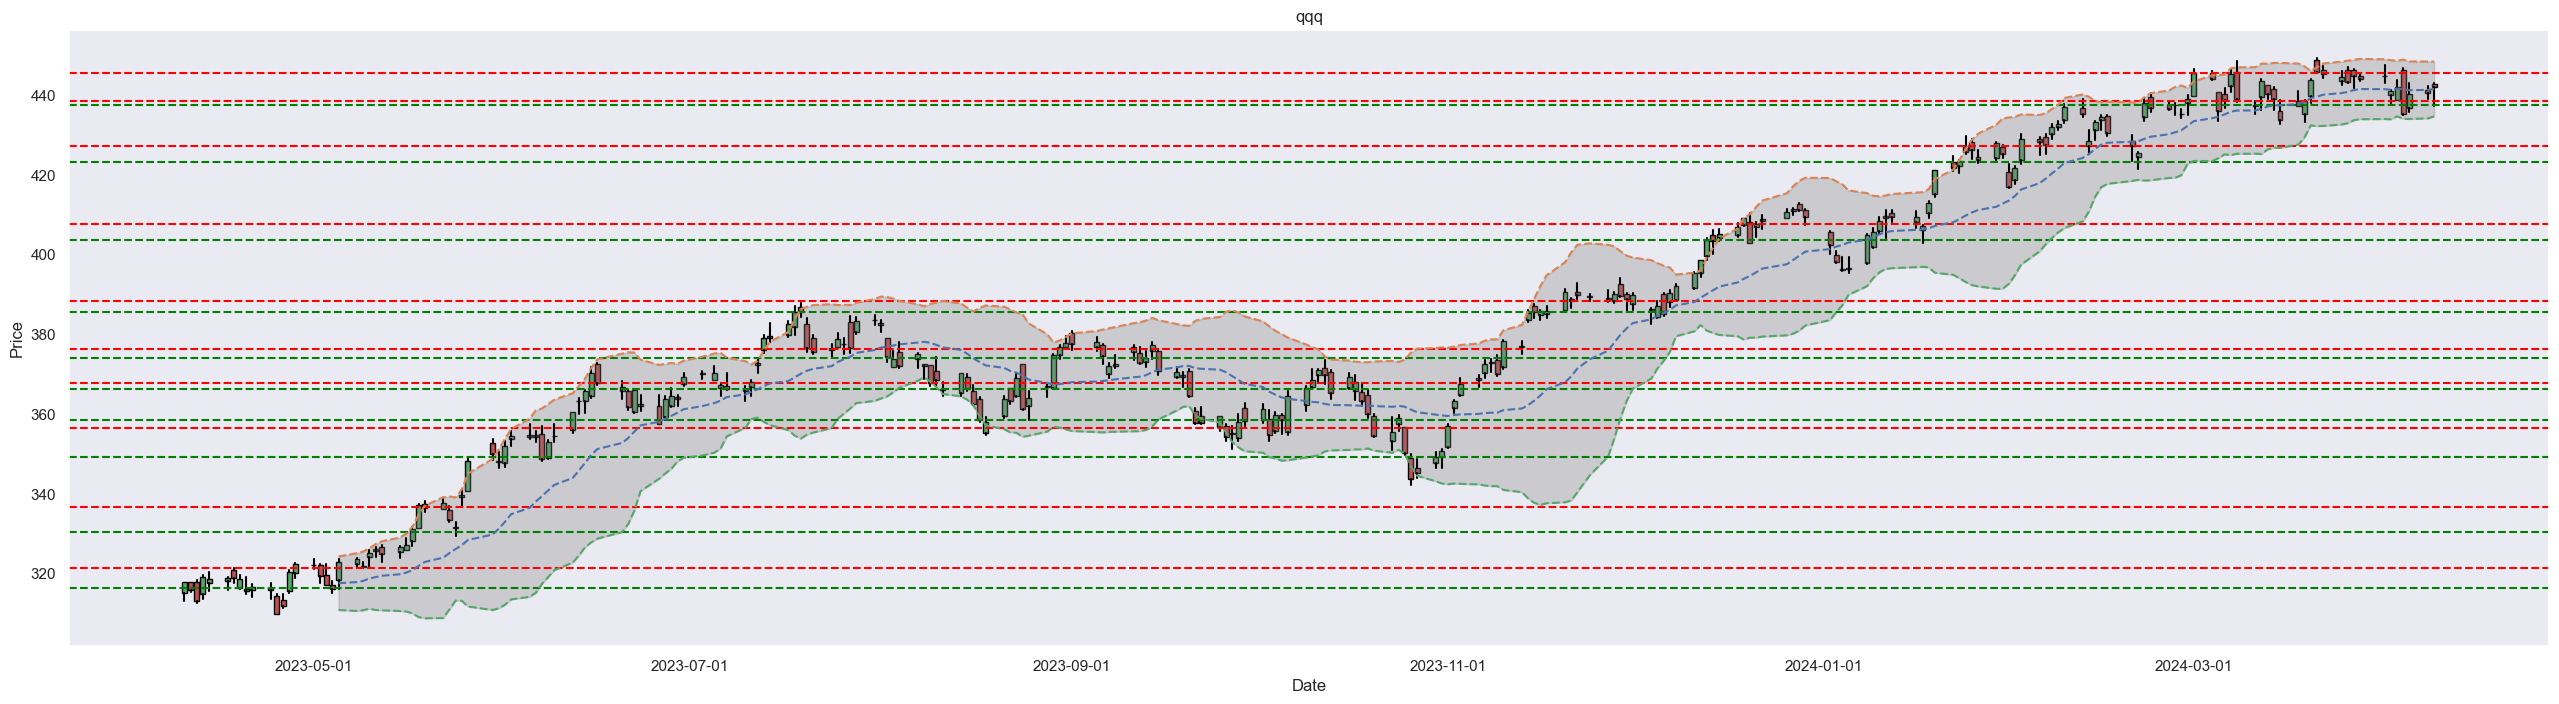

In [4]:
test_option_trading('qqq')

[*********************100%%**********************]  1 of 1 completed
2024-04-10
* previous stock price closing 60.52 ~ up 62.69 , down 58.57
Latest 20 Day MA: 60.6980001449585
Latest Lower Bollinger Band: 57.90650385841303
Latest Higher Bollinger Band: 63.489496431503966
[[26.98851854]
 [31.46642903]
 [35.3482353 ]
 [38.53046506]
 [41.60852937]
 [44.44772738]
 [49.11499996]
 [54.62187457]
 [58.57766698]
 [61.38400002]]
[[27.99962969]
 [32.09454536]
 [36.42032242]
 [39.61809494]
 [42.40705883]
 [45.41620675]
 [50.55952381]
 [56.54937434]
 [60.12545395]
 [62.68705862]]


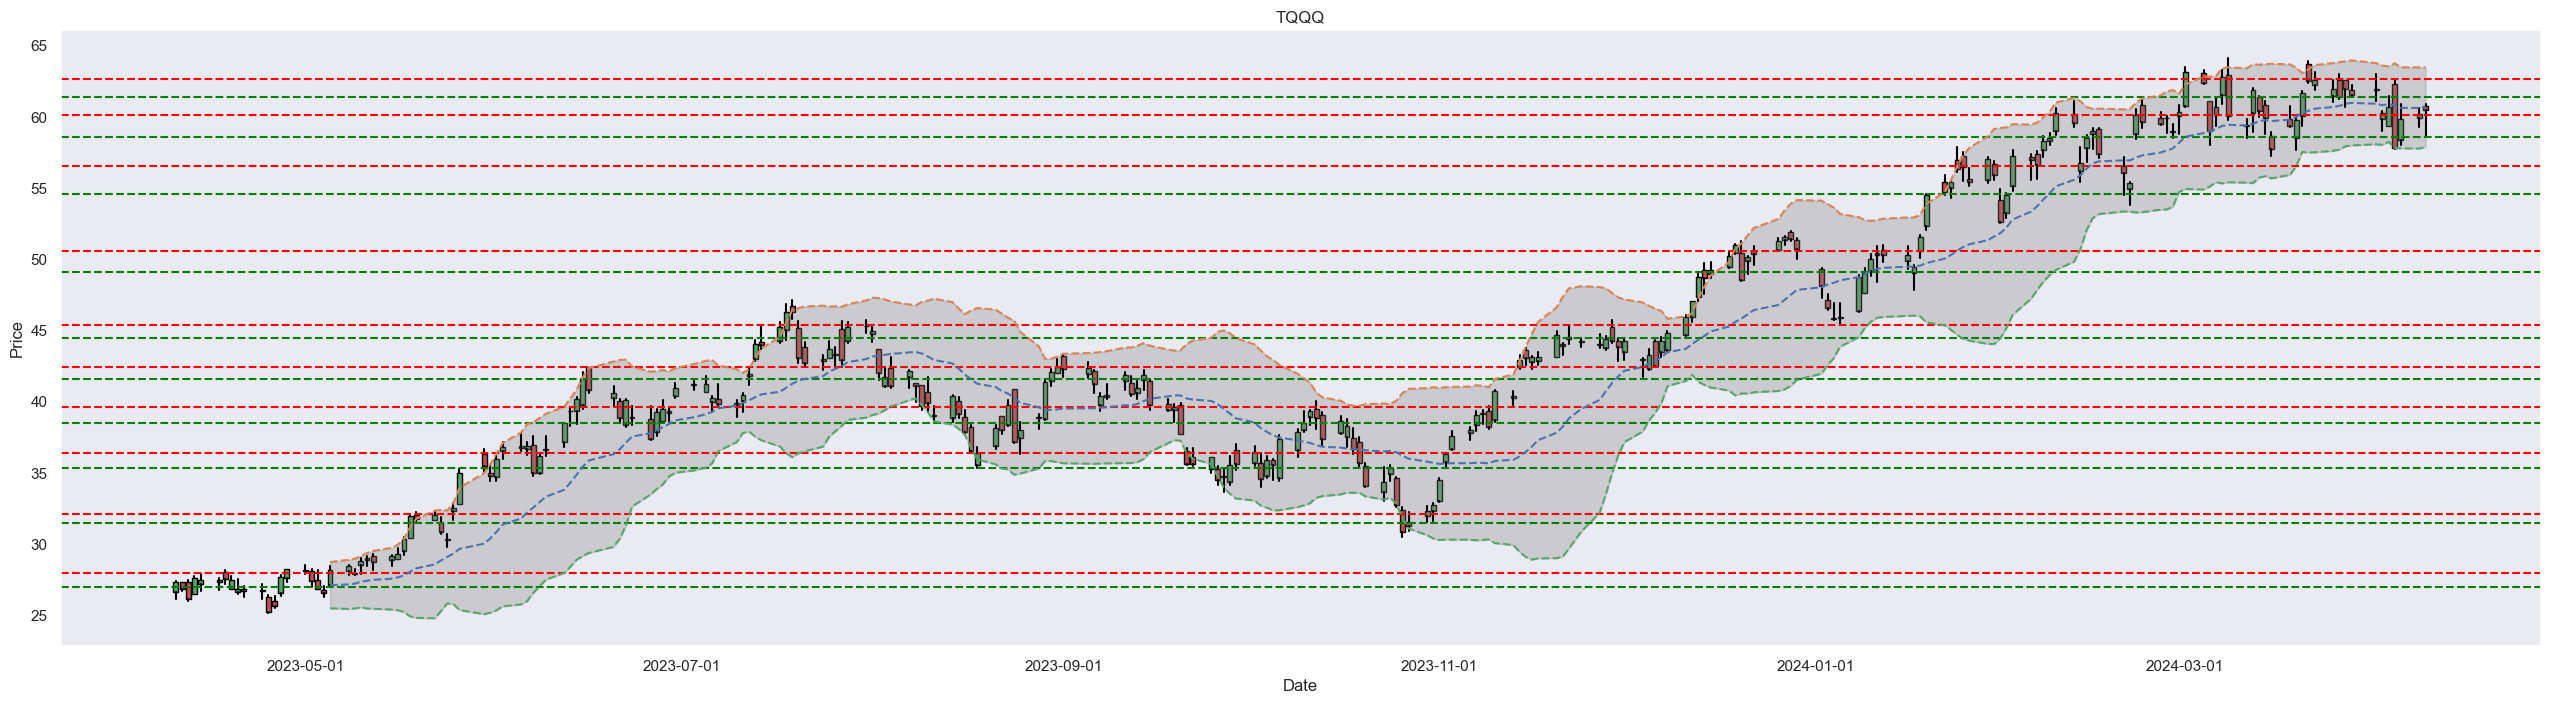

In [5]:
test_option_trading('TQQQ')

SPY & UPRO

[*********************100%%**********************]  1 of 1 completed
2024-04-10
* previous stock price closing 519.32 ~ up 520.23 , down 518.14
Latest 20 Day MA: 518.2379989624023
Latest Lower Bollinger Band: 510.9939999752614
Latest Higher Bollinger Band: 525.4819979495433
[[410.23684211]
 [422.23538325]
 [433.38567703]
 [442.83624935]
 [452.51281817]
 [470.99920166]
 [485.06777954]
 [494.95538095]
 [508.49947317]
 [518.1499939 ]]
[[414.61924973]
 [428.12538616]
 [439.24755385]
 [449.59774288]
 [457.31535775]
 [474.65583547]
 [488.05999756]
 [498.78076876]
 [510.41416677]
 [520.22047352]]


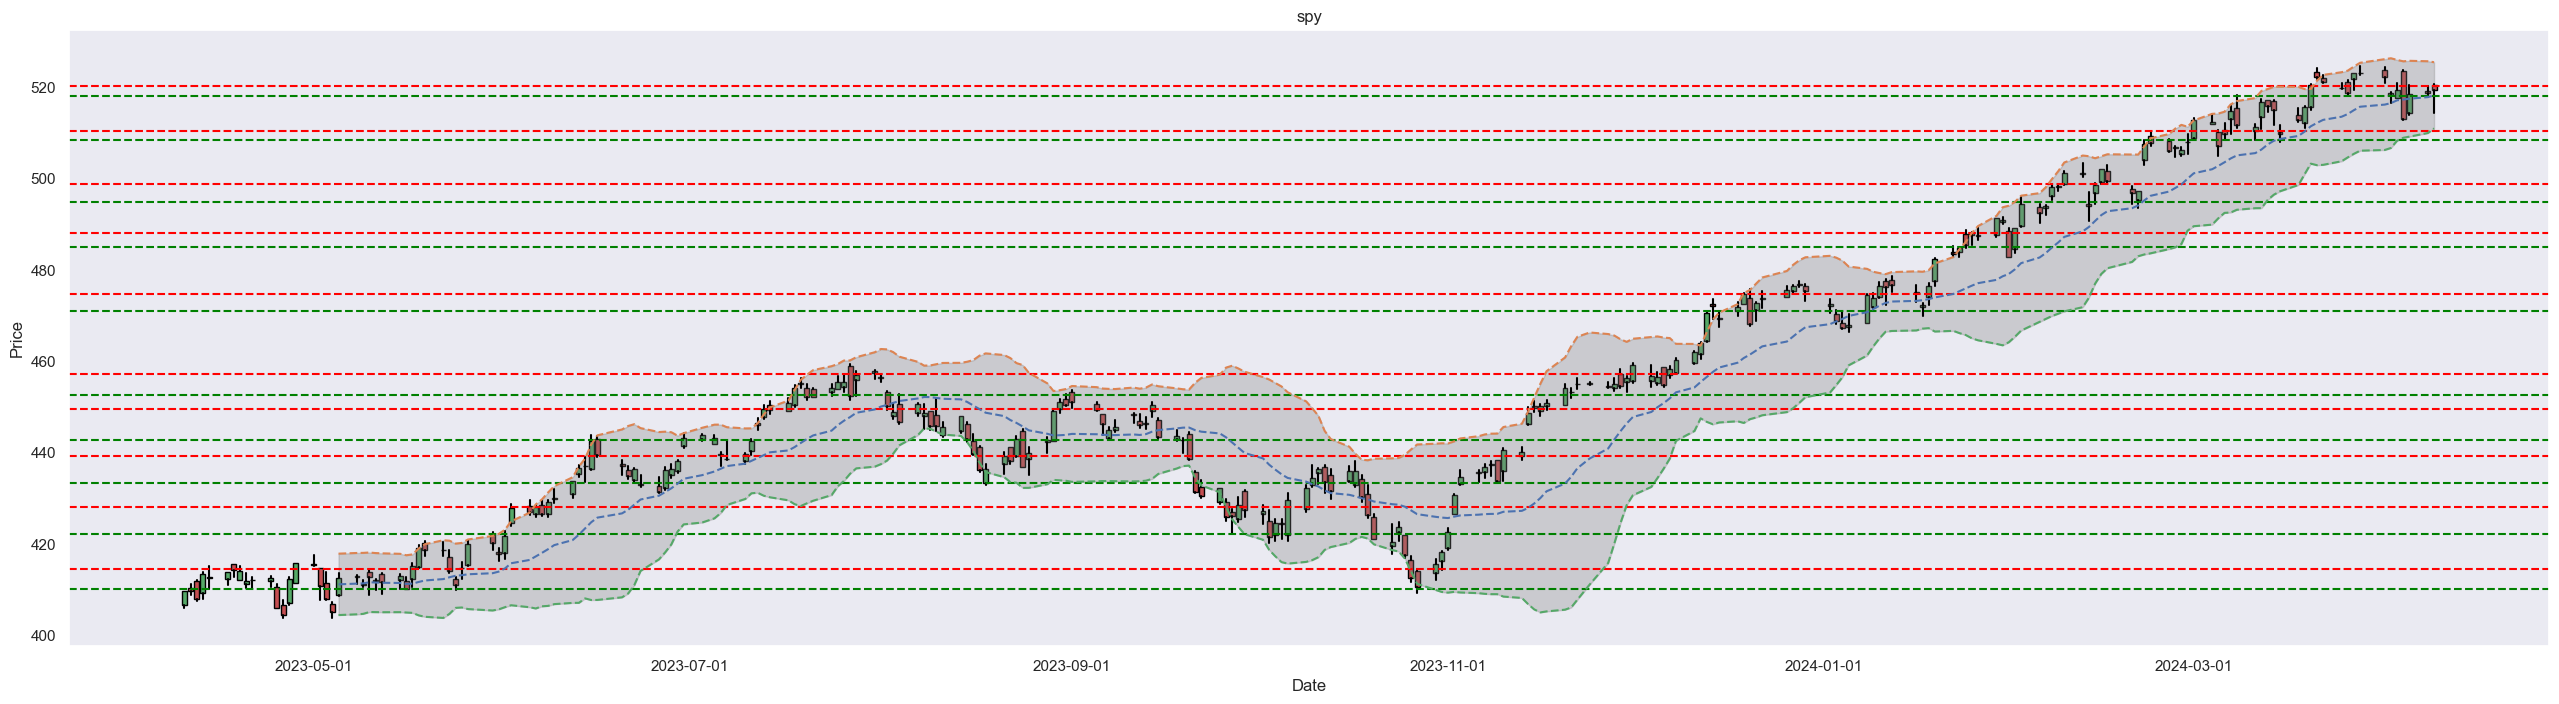

In [6]:
test_option_trading('spy')

[*********************100%%**********************]  1 of 1 completed
2024-04-10
* previous stock price closing 68.7 ~ up 69.43 , down 65.91
Latest 20 Day MA: 68.64649887084961
Latest Lower Bollinger Band: 65.85085953153398
Latest Higher Bollinger Band: 71.44213821016524
[[38.26102035]
 [41.80468786]
 [44.86599973]
 [47.4264445 ]
 [50.36133347]
 [53.49272693]
 [58.42250013]
 [62.78583336]
 [65.91199951]
 [69.0345452 ]]
[[39.35782615]
 [42.98029428]
 [46.14290324]
 [48.35923073]
 [50.76842117]
 [54.46416696]
 [58.58199997]
 [61.82333342]
 [65.72153796]
 [69.42714292]]


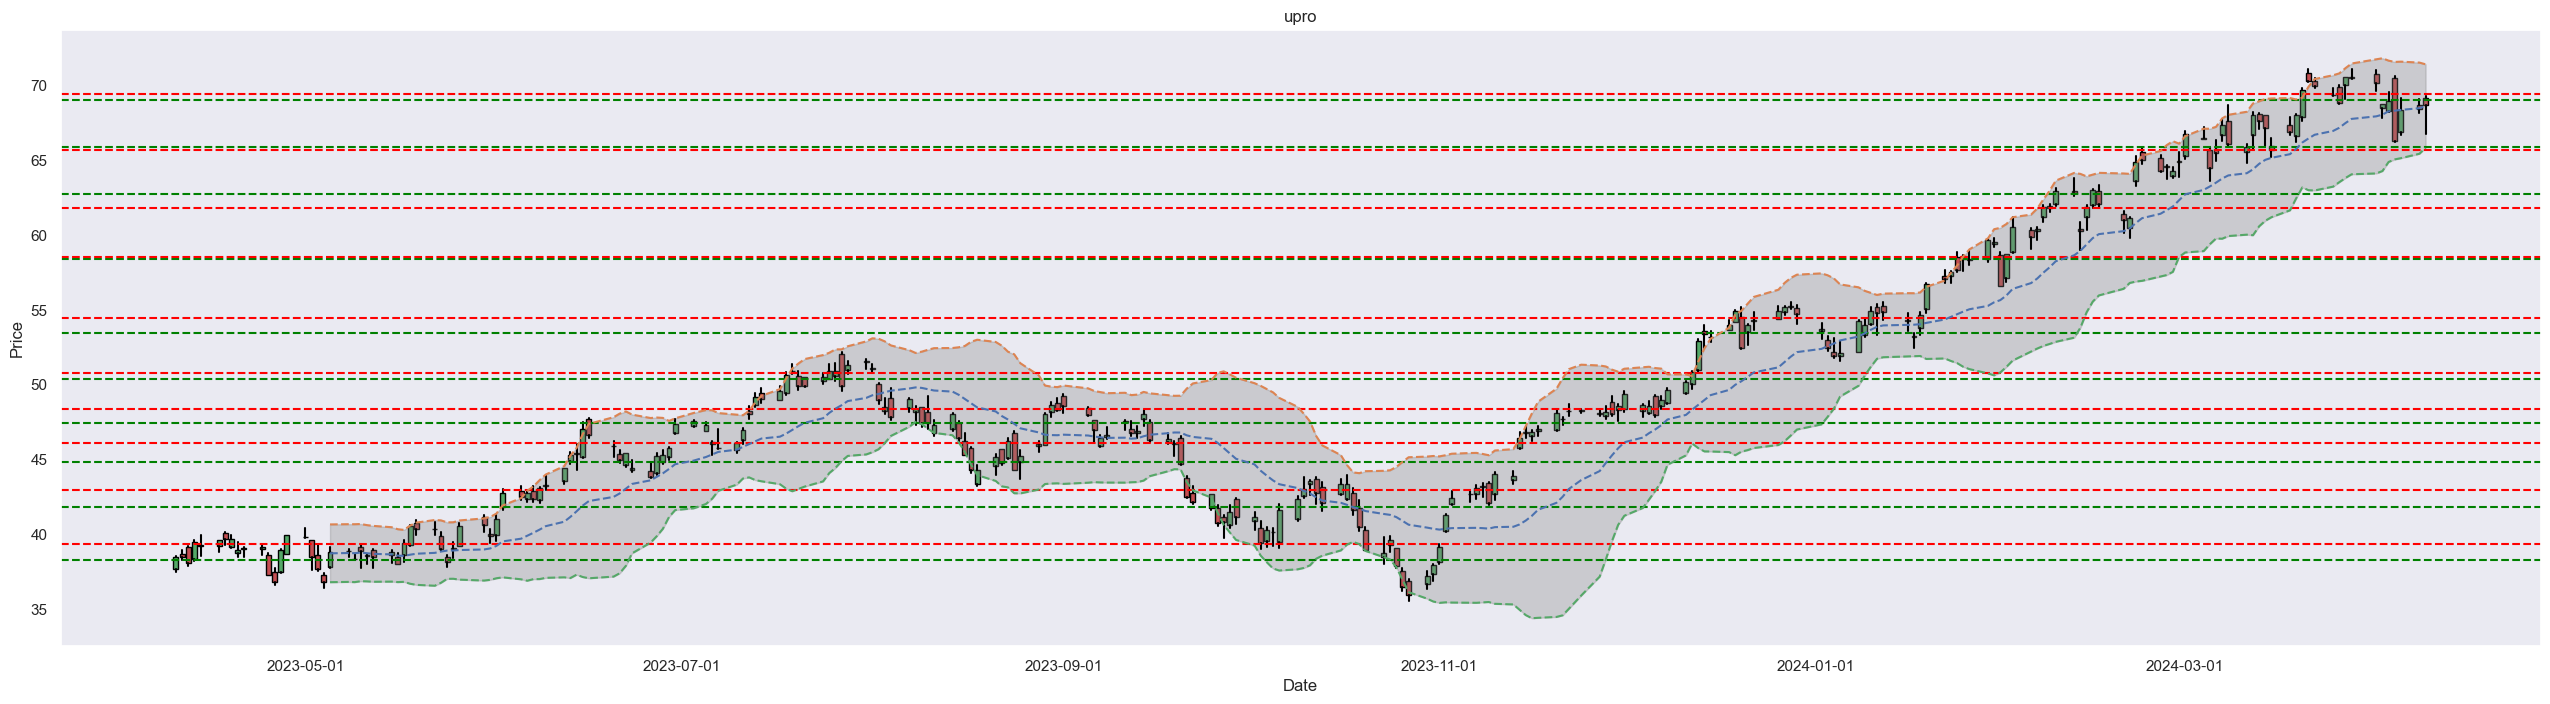

In [7]:
test_option_trading('upro')

SOXX & SOXL

[*********************100%%**********************]  1 of 1 completed
2024-04-10
* previous stock price closing 224.59 ~ up 228.24 , down 222.61
Latest 20 Day MA: 223.22299880981444
Latest Lower Bollinger Band: 216.37173343522218
Latest Higher Bollinger Band: 230.0742641844067
[[136.98884583]
 [145.77640827]
 [156.01120461]
 [162.29016337]
 [169.80449007]
 [181.33333435]
 [191.25666809]
 [200.49066569]
 [211.08333333]
 [222.61458206]]
[[139.08878812]
 [147.24104404]
 [158.64707114]
 [165.28634048]
 [171.75579701]
 [179.12142944]
 [190.10650253]
 [202.92395782]
 [214.71244405]
 [228.23833275]]


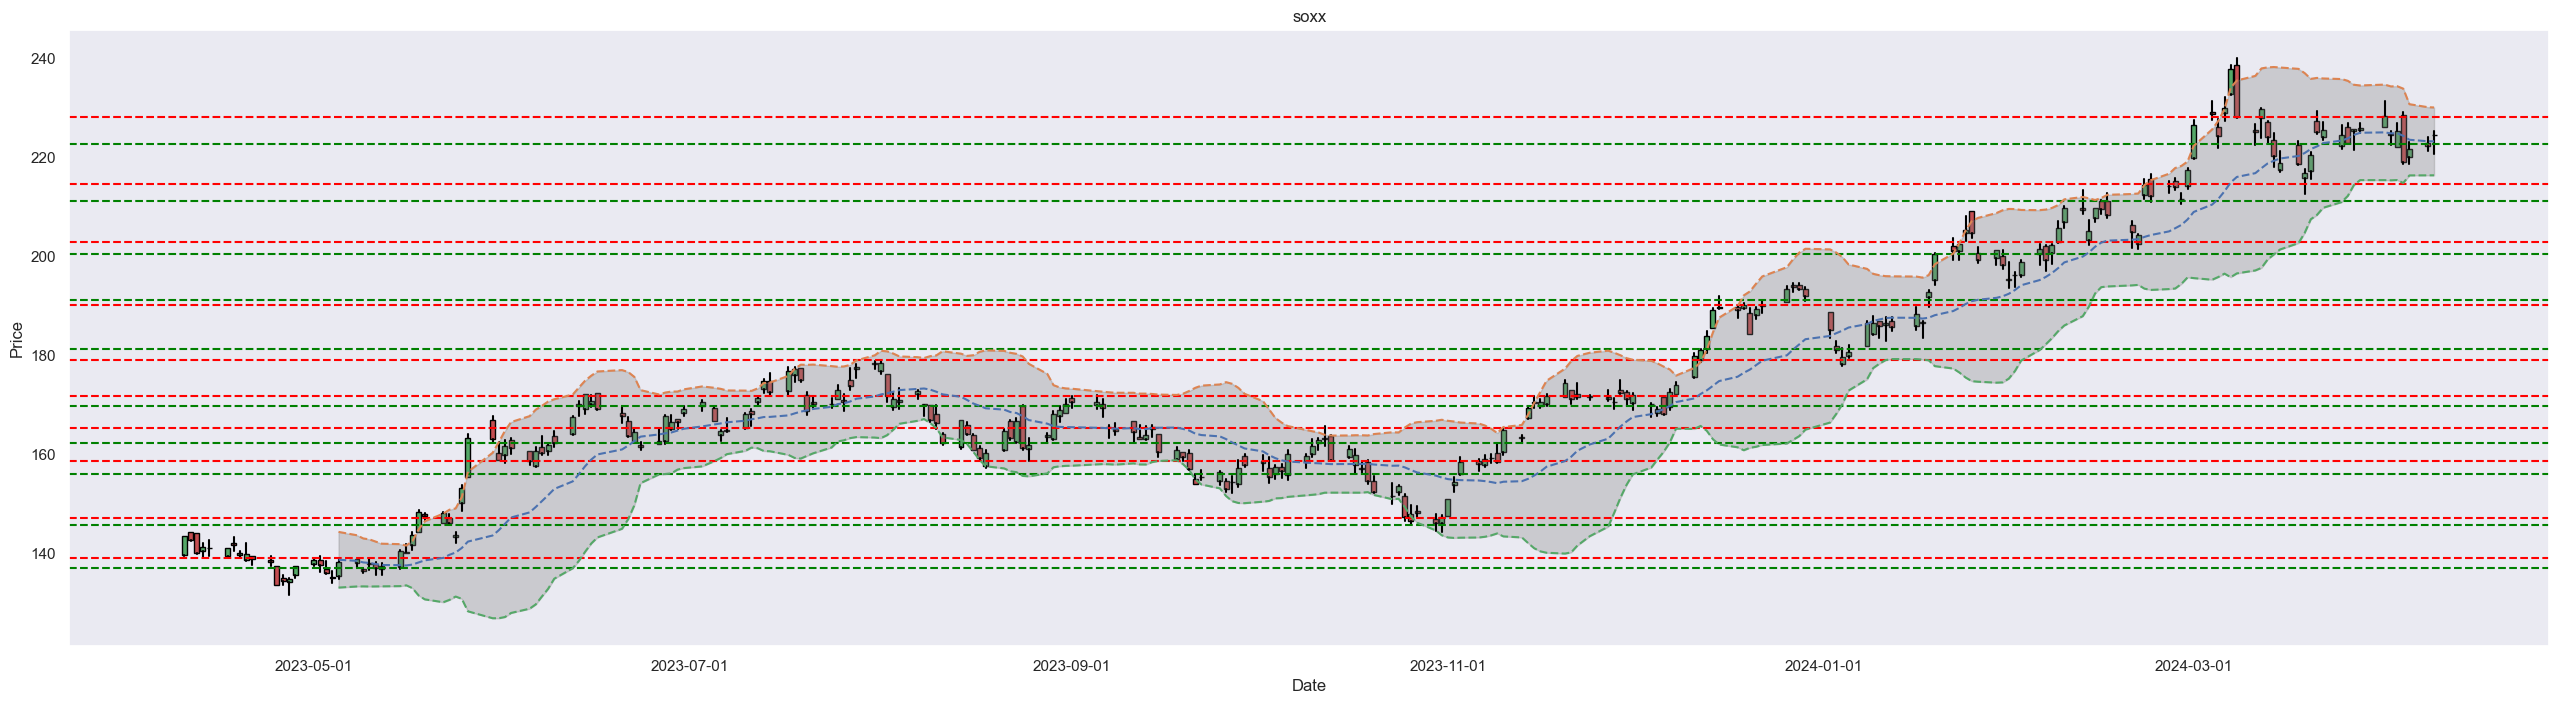

In [8]:
test_option_trading("soxx")

[*********************100%%**********************]  1 of 1 completed
2024-04-10
* previous stock price closing 45.39 ~ up 47.36 , down 44.86
Latest 20 Day MA: 45.07100009918213
Latest Lower Bollinger Band: 40.941837663761234
Latest Higher Bollinger Band: 49.200162534603024
[[14.39194449]
 [17.88948719]
 [21.21191487]
 [23.67461537]
 [26.7962501 ]
 [30.92733307]
 [34.68357113]
 [40.16058843]
 [44.86999989]
 [49.65499973]]
[[15.39971433]
 [19.1694872 ]
 [22.68086952]
 [25.26200013]
 [28.58947362]
 [31.5623075 ]
 [35.83133316]
 [41.35624981]
 [47.35549984]
 [54.07750034]]


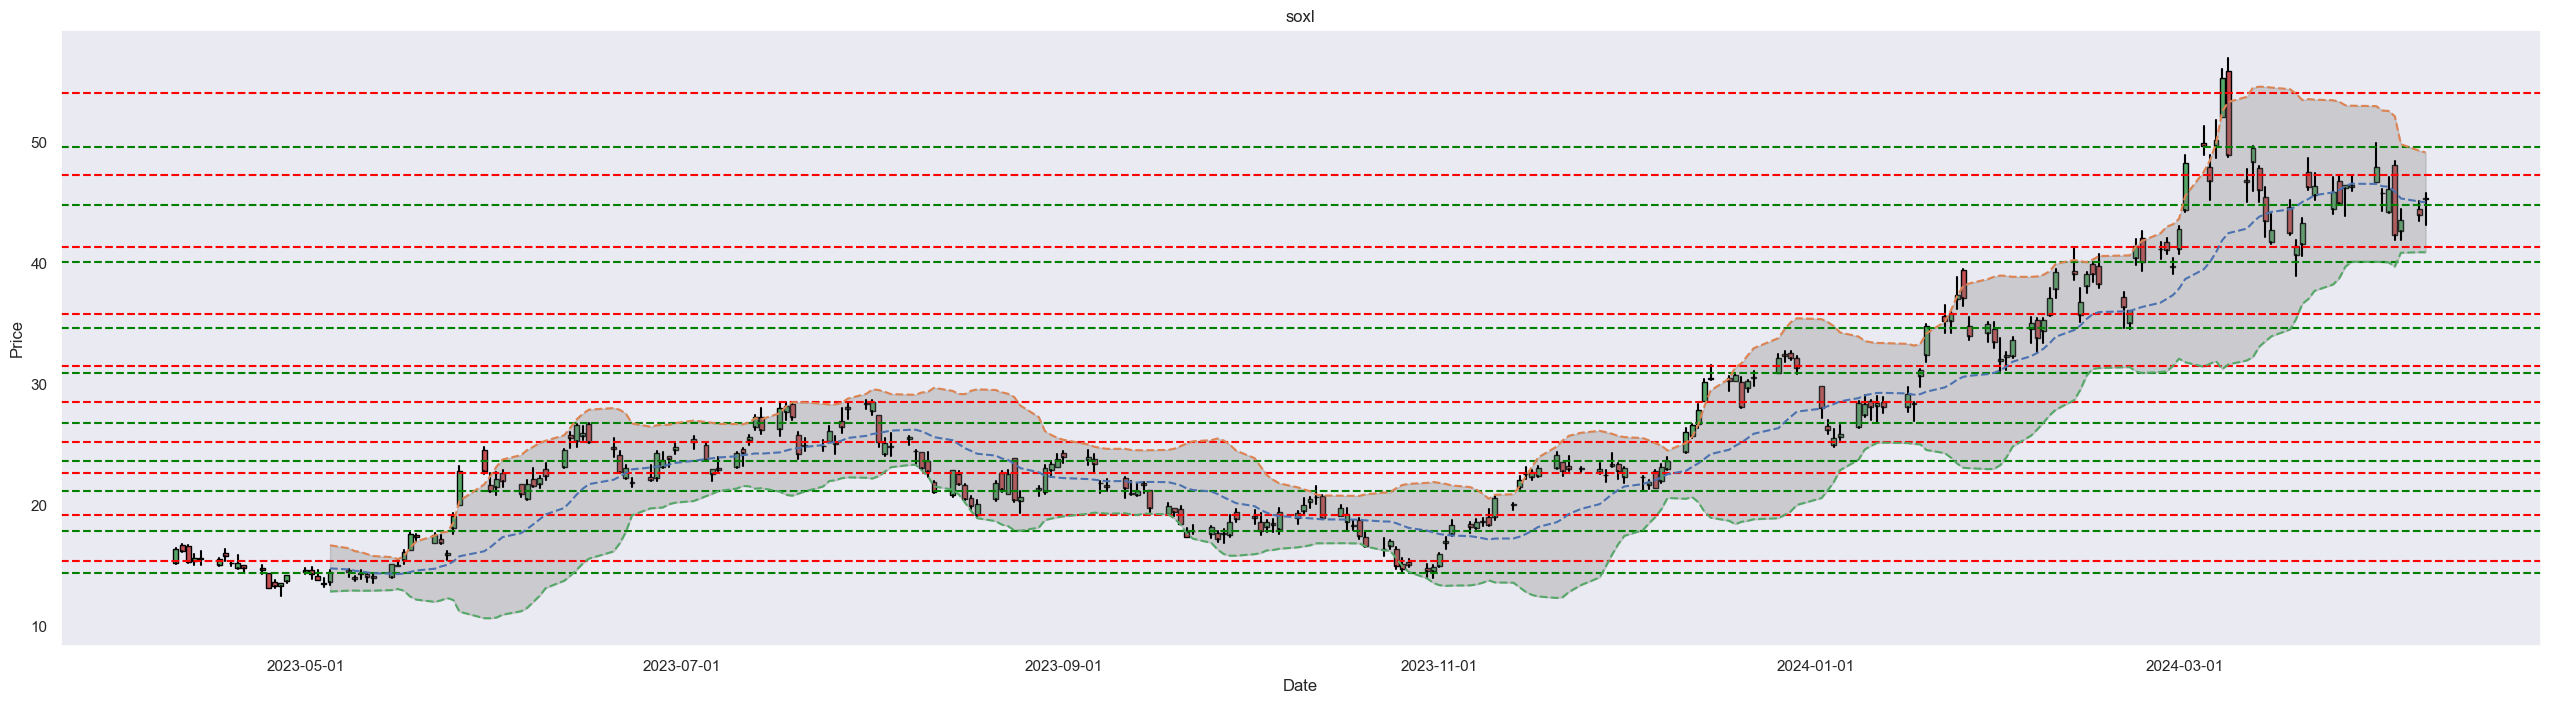

In [9]:
test_option_trading("soxl")

NVDA & NVDL

[*********************100%%**********************]  1 of 1 completed
2024-04-10
* previous stock price closing 853.54 ~ up 902.06 , down 774.8
Latest 20 Day MA: 897.9394989013672
Latest Lower Bollinger Band: 847.7477188575602
Latest Higher Bollinger Band: 948.1312789451741
[[278.62393743]
 [407.06678336]
 [447.16482491]
 [480.76225128]
 [545.05125427]
 [608.22299805]
 [693.71916707]
 [774.80999756]
 [856.74665934]
 [899.4827215 ]]
[[286.65030092]
 [423.27600047]
 [461.26520665]
 [490.84630419]
 [553.02750397]
 [622.8490878 ]
 [719.97332764]
 [803.31143624]
 [902.055231  ]
 [957.11800537]]


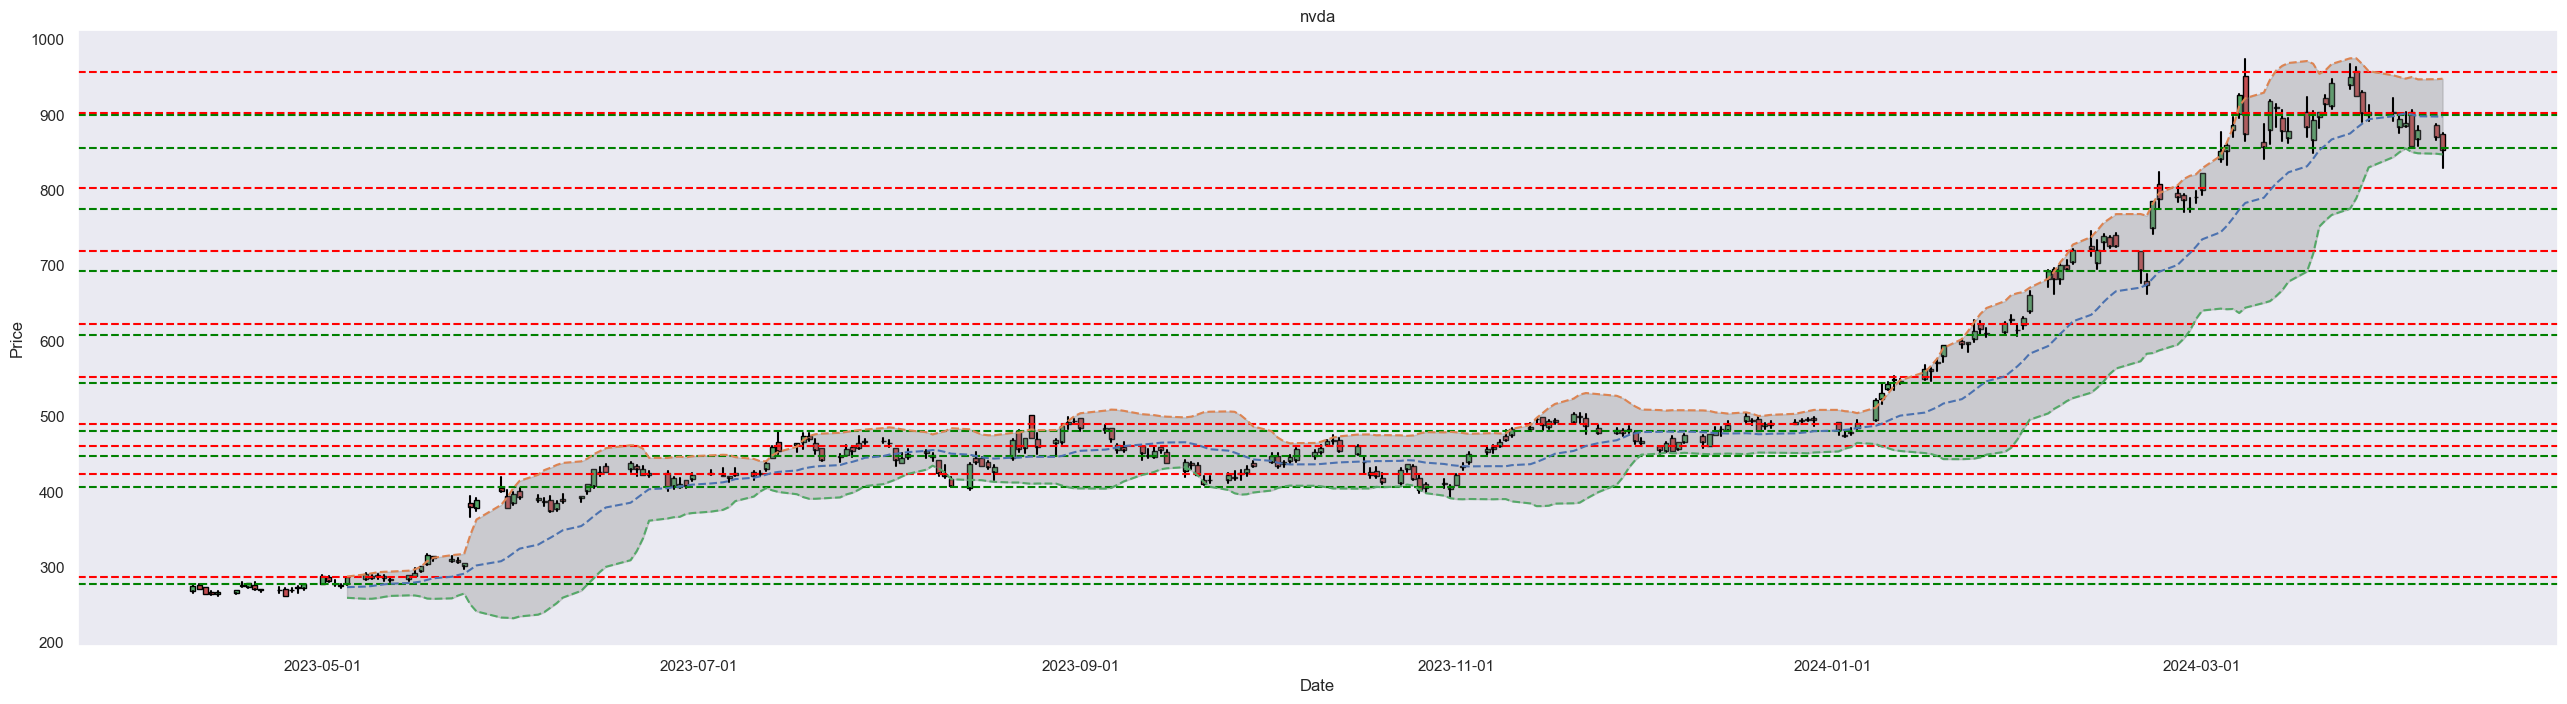

In [10]:
test_option_trading('nvda')

[*********************100%%**********************]  1 of 1 completed
2024-04-10
* previous stock price closing 36.88 ~ up 40.1 , down 32.39
Latest 20 Day MA: 41.243583297729494
Latest Lower Bollinger Band: 36.40342785727424
Latest Higher Bollinger Band: 46.08373873818475
[[ 7.82072047]
 [12.91547452]
 [14.66451474]
 [16.29059584]
 [19.93965034]
 [23.97666645]
 [27.63852024]
 [32.39659555]
 [38.12733307]
 [41.62736626]]
[[ 8.19912811]
 [13.46669287]
 [14.97714453]
 [16.74461222]
 [21.47888904]
 [28.11618074]
 [33.87278639]
 [40.09395838]
 [42.87742292]
 [47.64100075]]


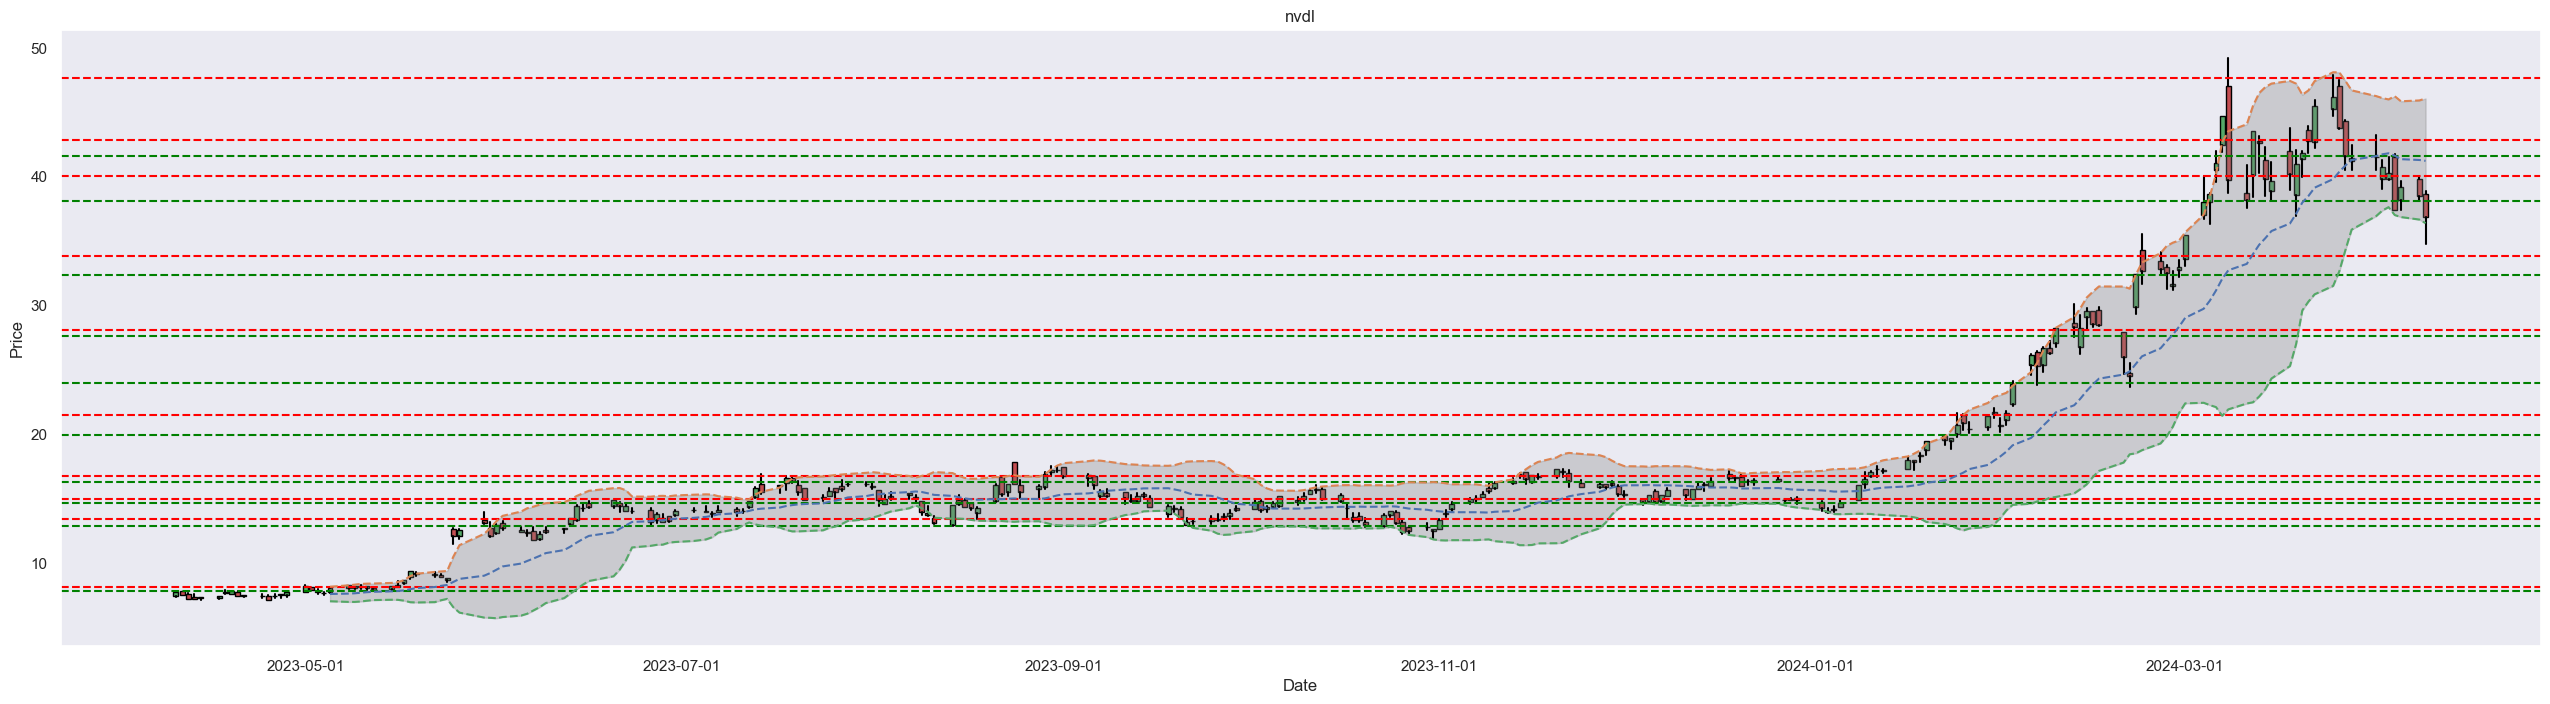

In [11]:
test_option_trading("nvdl")

Gld & UGL

[*********************100%%**********************]  1 of 1 completed
2024-04-10
Break all resistance; record max stock price
* previous stock price closing 217.67 ~ up 218.87 , down 212.92
Latest 20 Day MA: 205.45400161743163
Latest Lower Bollinger Band: 192.89391036453375
Latest Higher Bollinger Band: 218.0140928703295
[[169.41428702]
 [174.1881811 ]
 [177.90416686]
 [181.17622274]
 [183.89642915]
 [187.20207675]
 [189.85666826]
 [199.57875156]
 [206.17332967]
 [212.92000122]]
[[169.83600159]
 [174.7563643 ]
 [178.75565239]
 [181.95526244]
 [184.76022686]
 [188.12363697]
 [190.97833379]
 [199.50777859]
 [203.52000011]
 [214.78666687]]


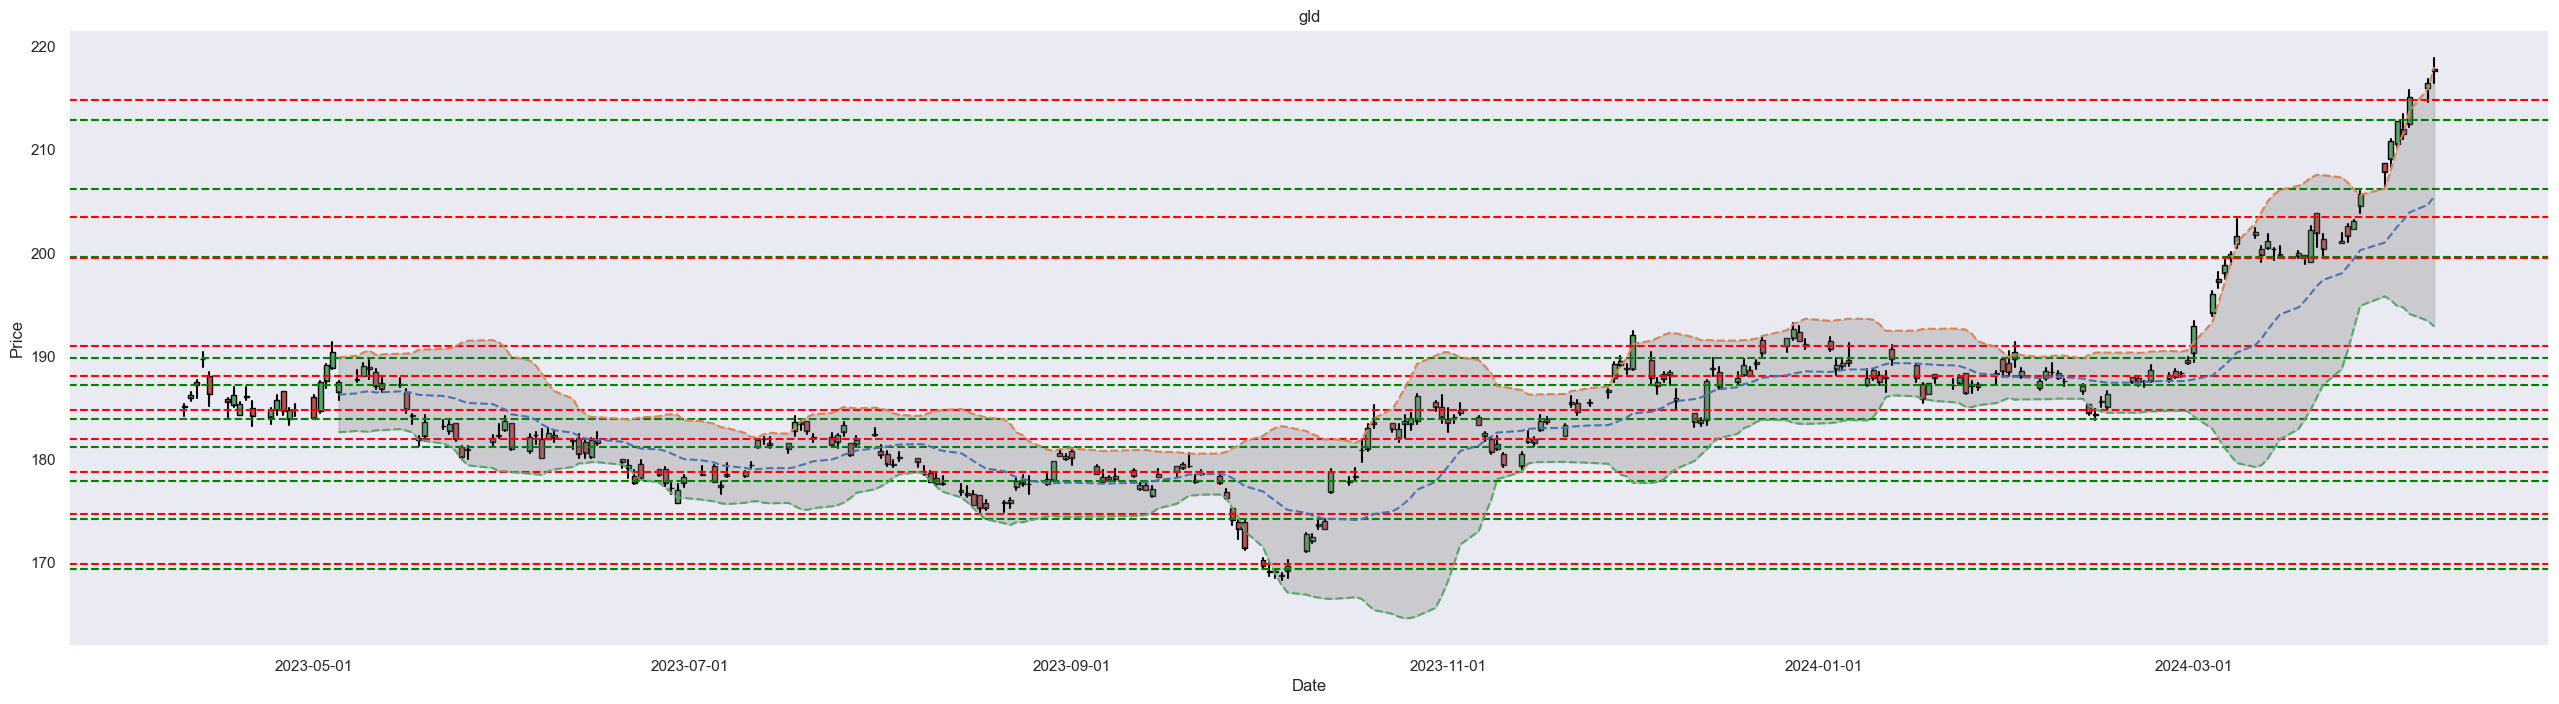

In [12]:
test_option_trading('gld')

[*********************100%%**********************]  1 of 1 completed
2024-04-10
Break all resistance; record max stock price
* previous stock price closing 80.69 ~ up 81.59 , down 78.37
Latest 20 Day MA: 72.21650009155273
Latest Lower Bollinger Band: 63.628577286136114
Latest Higher Bollinger Band: 80.80442289696936
[[52.23416646]
 [56.60057155]
 [58.42275   ]
 [60.23810347]
 [61.62452353]
 [63.76653847]
 [65.96222178]
 [68.76875019]
 [74.57500076]
 [78.3700002 ]]
[[52.86636422]
 [57.3714704 ]
 [59.24578948]
 [61.12777758]
 [62.63571467]
 [64.77666677]
 [67.9371436 ]
 [70.54299927]
 [76.33500099]
 [80.34999847]]


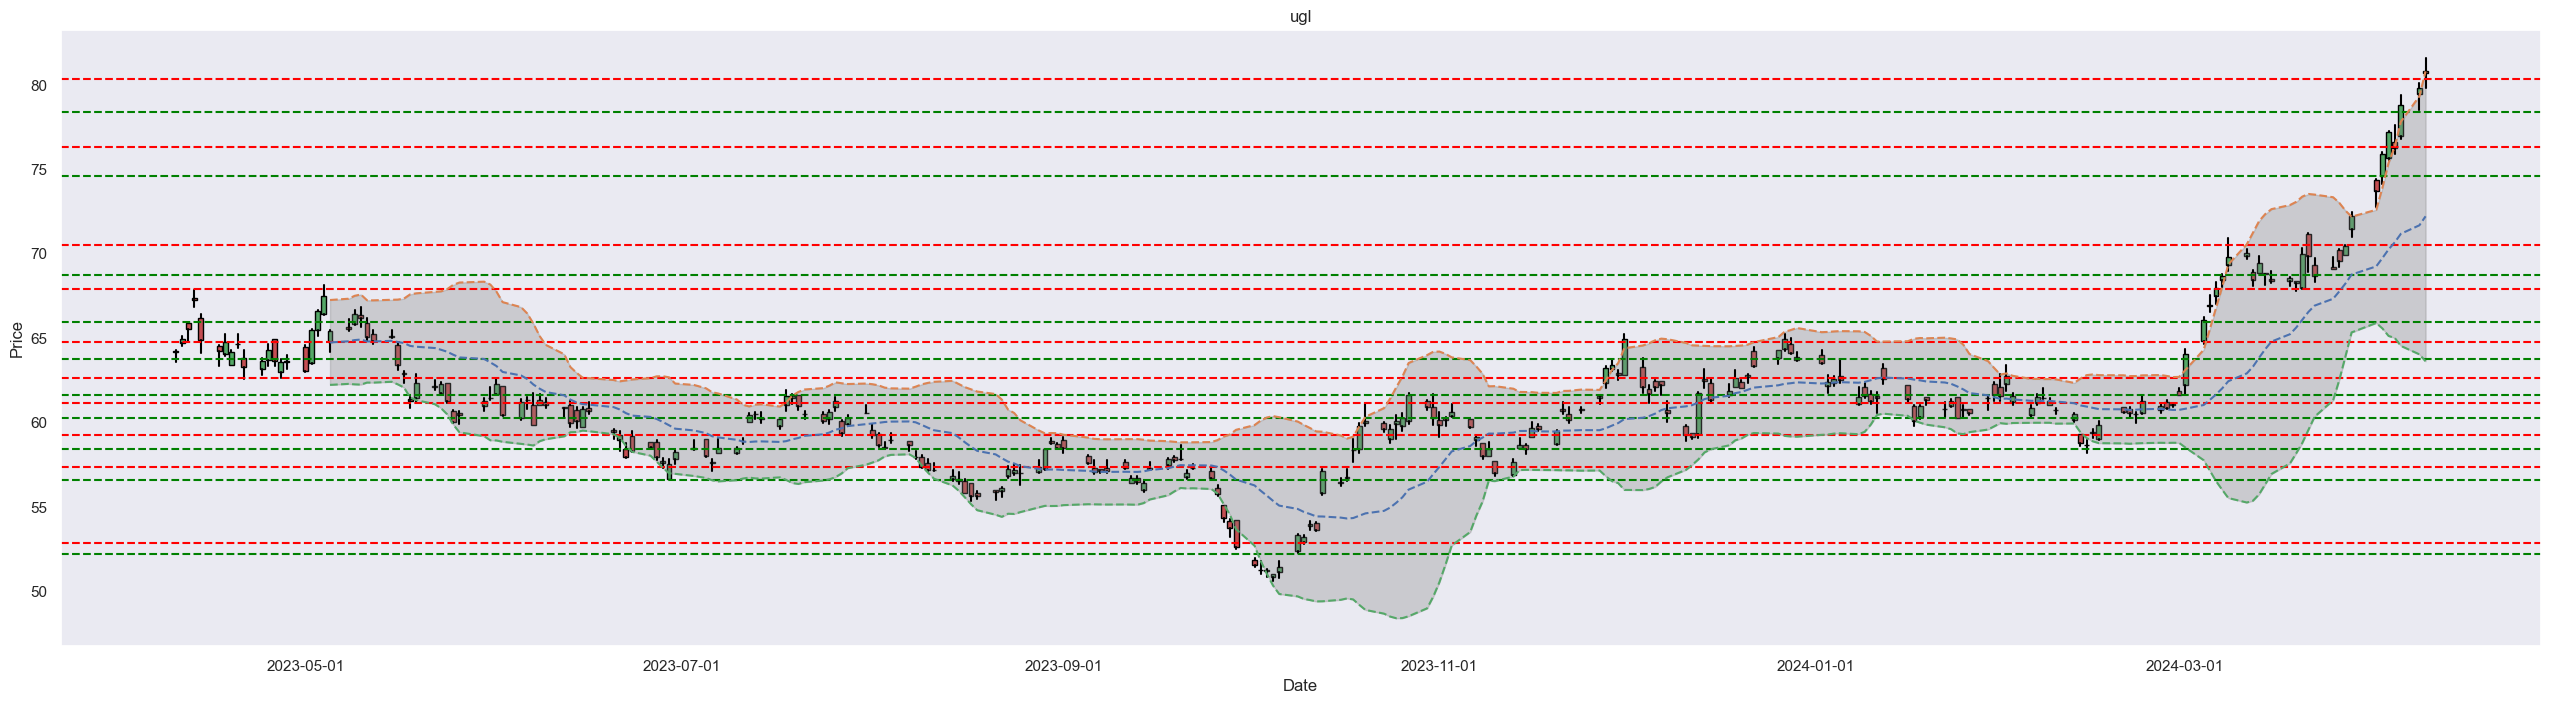

In [13]:
test_option_trading('ugl')

Random stocks

[*********************100%%**********************]  1 of 1 completed
2024-04-10
* previous stock price closing 176.88 ~ up 177.58 , down 170.58
Latest 20 Day MA: 171.97700119018555
Latest Lower Bollinger Band: 162.20065068805505
Latest Higher Bollinger Band: 181.75335169231604
[[160.015262  ]
 [170.58777647]
 [181.98500007]
 [194.85299911]
 [211.90535682]
 [230.9176651 ]
 [241.00968647]
 [250.76030338]
 [261.27652243]
 [276.52083333]]
[[166.78571356]
 [177.57250023]
 [188.67964281]
 [202.65350266]
 [219.70481477]
 [239.43583383]
 [251.33428683]
 [260.99594446]
 [274.22833379]
 [290.03000387]]


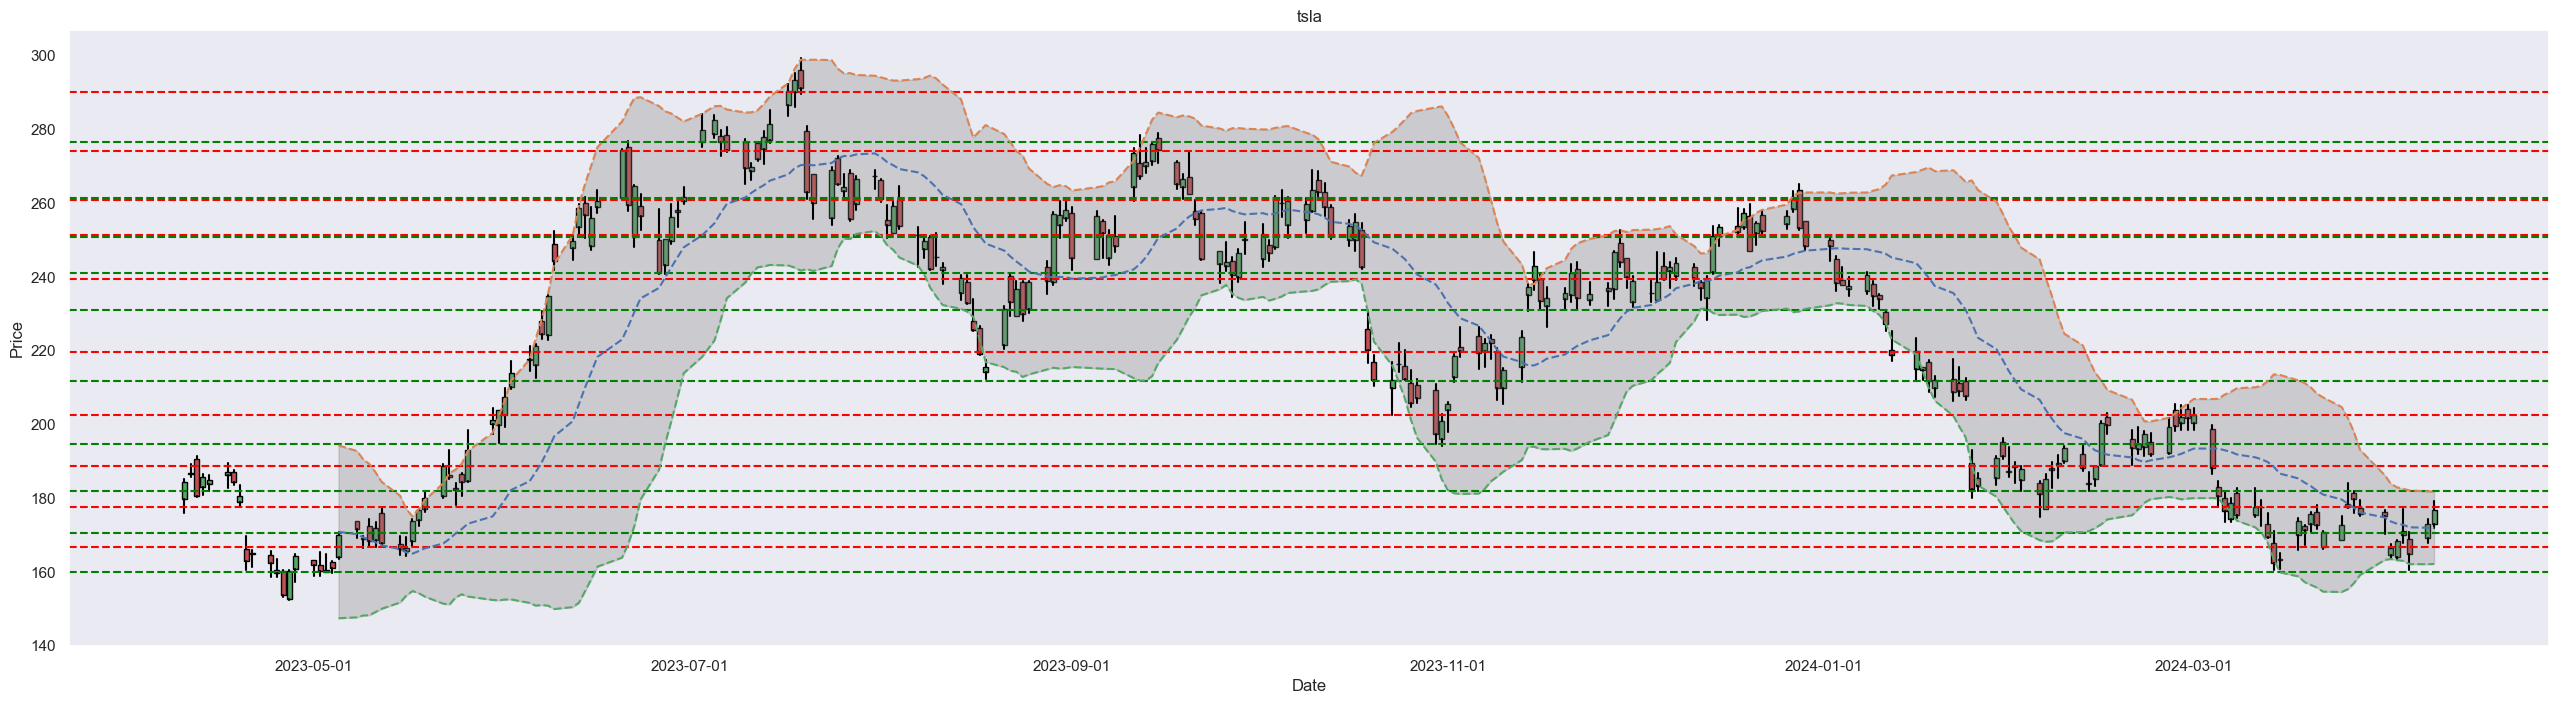

In [14]:
test_option_trading('tsla')

[*********************100%%**********************]  1 of 1 completed
2024-04-10
* previous stock price closing 69139.02 ~ up 69792.99 , down 66437.94
Latest 20 Day MA: 68404.535546875
Latest Lower Bollinger Band: 63754.75110948993
Latest Higher Bollinger Band: 73054.31998426007
[[17996.4943704 ]
 [21944.37313702]
 [26639.8691276 ]
 [30012.03321606]
 [35873.60310872]
 [41497.52099905]
 [46690.71847345]
 [53273.62943412]
 [59276.91690341]
 [66437.94811699]]
[[18091.78819971]
 [22170.99416684]
 [27158.33203125]
 [30772.2983817 ]
 [37500.13164839]
 [43025.94639757]
 [49361.99797762]
 [57899.77996505]
 [62933.24549932]
 [69792.98647104]]


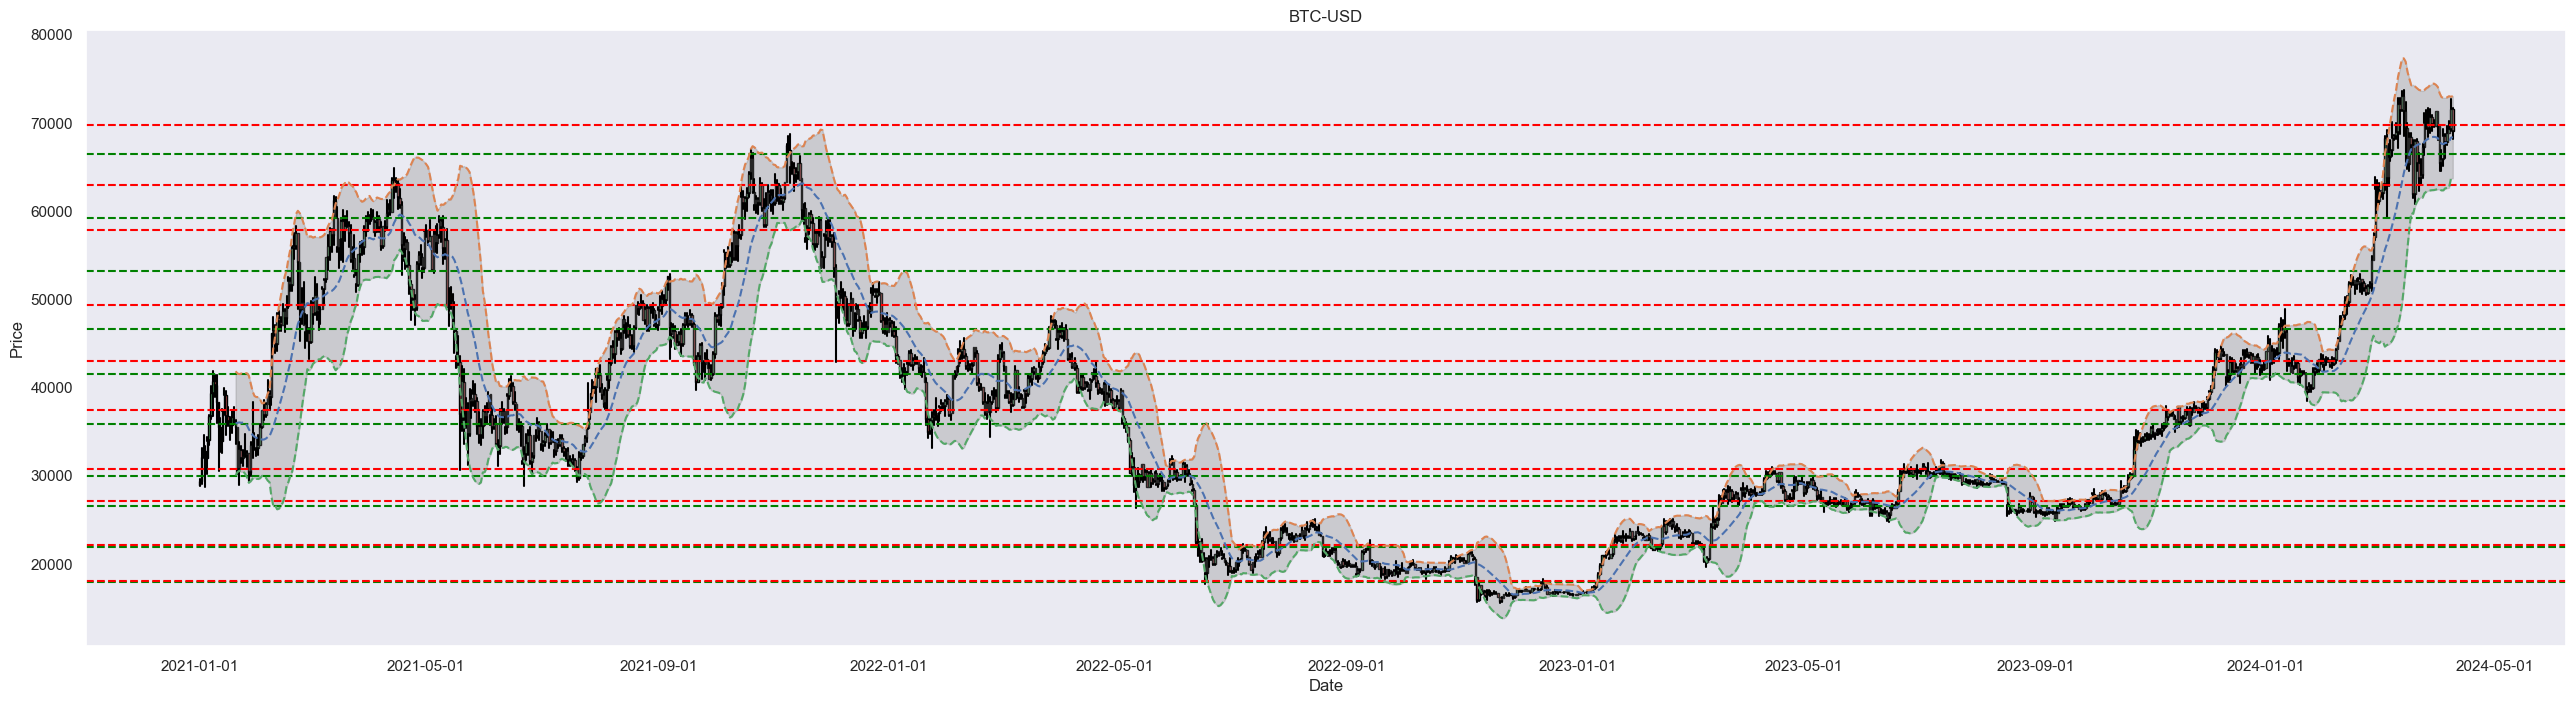

In [15]:
test_option_trading('BTC-USD', start='2021-01-01')